# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ensure dependencies are installed
#!pip install polars
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install flax
#!pip install scikit-image
#!pip install git+https://github.com/wcarvalho/nicewebrl
#!pip install git+https://github.com/wcarvalho/JaxHouseMaze.git
#!pip install --upgrade git+https://github.com/wcarvalho/JaxHouseMaze.git
#!pip install --upgrade --force --no-cache-dir git+https://github.com/wcarvalho/nicewebrl

In [3]:
# import packages
import os
from os.path import join as opj
import sys

# add parent directory to current path
cdir=os.getcwd()
parent_dir = os.path.dirname(cdir)
sys.path.append(parent_dir)
print(parent_dir)

from typing import List
import numpy as np
import scipy
import fnmatch

import json
import copy
import load_data
from pprint import pprint
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import experiment_1 as experiment

from collections import defaultdict
import jax.numpy as jnp
import jax.tree_util as jtu
import jax

from load_data import get_timestep, compute_reaction_time, EpisodeData
from load_data import render_episode, get_task_object, object_idx_to_name, success_fn, get_task_room, create_maps
from load_data import filter_episodes


/Users/hall-mcmaster/Documents/Projects/Maze/human-dyna-web


# Define functions

In [8]:
# locate relevant files
def list_files(directory):
    fnames=[]
    for root, dirs, files in os.walk(directory):
        for file in files:
            cfile=opj(root,file)
            fnames.append(cfile)
    return fnames

In [9]:
# check for .DS_Store files
def is_ds_store(filename):
    return fnmatch.fnmatch(filename, '*.DS_Store')

In [4]:
# run RT analyses
def run_RT_analysis(RTs_on_path_allsubs, RTs_off_path_allsubs, title_str, path_str):
    # Convert to arrays with padding to handle unequal sequence lengths
    max_len_on = max([len(sub) for sub in RTs_on_path_allsubs])
    max_len_off = max([len(sub) for sub in RTs_off_path_allsubs])
    
    RTs_on_path_allsubs_padded = np.array([np.pad(sub, (0, max_len_on - len(sub)), constant_values=np.nan) for sub in RTs_on_path_allsubs])
    RTs_off_path_allsubs_padded = np.array([np.pad(sub, (0, max_len_off - len(sub)), constant_values=np.nan) for sub in RTs_off_path_allsubs])
    
    # Duration (episode length)
    duration_on_path = np.nansum(RTs_on_path_allsubs_padded, axis=1)
    duration_off_path = np.nansum(RTs_off_path_allsubs_padded, axis=1)
    
    # Descriptive statistics
    mean_duration_on_path = np.nanmean(duration_on_path)
    mean_duration_off_path = np.nanmean(duration_off_path)
    sem_on_path = np.nanstd(duration_on_path) / np.sqrt(len(duration_on_path))
    sem_off_path = np.nanstd(duration_off_path) / np.sqrt(len(duration_off_path))
    
    # Test the prediction (paired t-test or Wilcoxon signed-rank test)
    diff = duration_off_path - duration_on_path
    shapiro_test = scipy.stats.shapiro(diff)
    
    if shapiro_test.pvalue > 0.05:
        test_stat, p_value = scipy.stats.ttest_rel(duration_on_path, duration_off_path, nan_policy='omit')
        test_type = 'Paired t-test'
    else:
        test_stat, p_value = scipy.stats.wilcoxon(duration_on_path, duration_off_path)
        test_type = 'Wilcoxon signed-rank test'
    
    # Print the results for episode duration
    print(f"Shapiro-Wilk test p-value (duration): {shapiro_test.pvalue}")
    print(f"{test_type} statistic (duration): {test_stat}")
    print(f"{test_type} p-value (duration): {p_value}")
    
    # Create the summary plot for mean episode durations
    means = [mean_duration_on_path, mean_duration_off_path]
    sems = [sem_on_path, sem_off_path]
    
    fig, ax = plt.subplots()
    ax.bar(path_str, means, yerr=sems, capsize=5, color=['#F28E2B', '#4E79A7'], alpha=0.7)
    ax.set_ylabel('Mean Episode Duration (ms)')
    ax.set_title(title_str)
    plt.show()
    
    # RTs as a function of action number
    max_len = max(max_len_on, max_len_off)
    mean_RTs_on_path = np.nanmean(RTs_on_path_allsubs_padded, axis=0)
    mean_RTs_off_path = np.nanmean(RTs_off_path_allsubs_padded, axis=0)
    sem_RTs_on_path = np.nanstd(RTs_on_path_allsubs_padded, axis=0, ddof=1) / np.sqrt(RTs_on_path_allsubs_padded.shape[0])
    sem_RTs_off_path = np.nanstd(RTs_off_path_allsubs_padded, axis=0, ddof=1) / np.sqrt(RTs_off_path_allsubs_padded.shape[0])
    
    # Pad the mean and SEM arrays to the same length
    mean_RTs_on_path = np.pad(mean_RTs_on_path, (0, max_len - len(mean_RTs_on_path)), constant_values=np.nan)
    mean_RTs_off_path = np.pad(mean_RTs_off_path, (0, max_len - len(mean_RTs_off_path)), constant_values=np.nan)
    sem_RTs_on_path = np.pad(sem_RTs_on_path, (0, max_len - len(sem_RTs_on_path)), constant_values=np.nan)
    sem_RTs_off_path = np.pad(sem_RTs_off_path, (0, max_len - len(sem_RTs_off_path)), constant_values=np.nan)

    # Plot RTs as a function of action
    x = np.arange(1, max_len + 1)
    fig, ax = plt.subplots()
    ax.bar(x - 0.17, mean_RTs_on_path, width=0.35, yerr=sem_RTs_on_path, capsize=5, label='On-path', color='#F28E2B', alpha=0.7)
    ax.bar(x + 0.17, mean_RTs_off_path, width=0.35, yerr=sem_RTs_off_path, capsize=5, label='Off-path', color='#4E79A7', alpha=0.7)
    ax.set_xlabel('Action Number')
    ax.set_ylabel('Reaction Time (ms)')
    ax.set_title(title_str)
    ax.legend()
    plt.show()
    
    # Add the first RT comparison
    first_RTs_on_path = RTs_on_path_allsubs_padded[:, 0]
    first_RTs_off_path = RTs_off_path_allsubs_padded[:, 0]

    mean_first_RT_on_path = np.nanmean(first_RTs_on_path)
    mean_first_RT_off_path = np.nanmean(first_RTs_off_path)
    sem_first_RT_on_path = np.nanstd(first_RTs_on_path) / np.sqrt(np.count_nonzero(~np.isnan(first_RTs_on_path)))
    sem_first_RT_off_path = np.nanstd(first_RTs_off_path) / np.sqrt(np.count_nonzero(~np.isnan(first_RTs_off_path)))

    # Perform statistical test on first RTs
    first_RT_diff = first_RTs_off_path - first_RTs_on_path
    shapiro_test_first_RT = scipy.stats.shapiro(first_RT_diff)

    if shapiro_test_first_RT.pvalue > 0.05:
        test_stat_first_RT, p_value_first_RT = scipy.stats.ttest_rel(first_RTs_on_path, first_RTs_off_path, nan_policy='omit')
        test_type_first_RT = 'Paired t-test'
    else:
        test_stat_first_RT, p_value_first_RT = scipy.stats.wilcoxon(first_RTs_on_path, first_RTs_off_path)
        test_type_first_RT = 'Wilcoxon signed-rank test'

    # Print results for the first RT test
    print(f"Shapiro-Wilk test p-value (first RT): {shapiro_test_first_RT.pvalue}")
    print(f"{test_type_first_RT} statistic (first RT): {test_stat_first_RT}")
    print(f"{test_type_first_RT} p-value (first RT): {p_value_first_RT}")

    # Plot the first RT comparison
    fig, ax = plt.subplots()
    ax.bar(['On-path', 'Off-path'], [mean_first_RT_on_path, mean_first_RT_off_path], 
           yerr=[sem_first_RT_on_path, sem_first_RT_off_path], capsize=5, color=['#F28E2B', '#4E79A7'], alpha=0.7)
    ax.set_ylabel('First Action RT (ms)')
    ax.set_title(title_str)
    plt.show()

    # Return results as a dictionary for further analysis
    return {
        'mean_duration_on_path': mean_duration_on_path,
        'mean_duration_off_path': mean_duration_off_path,
        'test_stat': test_stat,
        'p_value': p_value,
        'test_type': test_type,
        'mean_first_RT_on_path': mean_first_RT_on_path,
        'mean_first_RT_off_path': mean_first_RT_off_path,
        'sem_first_RT_on_path': sem_first_RT_on_path,
        'sem_first_RT_off_path': sem_first_RT_off_path,
        'test_stat_first_RT': test_stat_first_RT,
        'p_value_first_RT': p_value_first_RT,
        'test_type_first_RT': test_type_first_RT
    }


In [49]:
# run intersection analysis
def run_intersection_analysis(old_path_allsubs, title_str):
    # Shapiro-Wilk test for normality
    shapiro_test = scipy.stats.shapiro(old_path_allsubs)
    print('Shapiro-Wilk test result:', shapiro_test)
    
    # Check if the data is normally distributed
    if shapiro_test.pvalue > 0.05:
        # Data is normally distributed, use one-sample t-test
        print("Data is normally distributed. Proceeding with t-test.")
        ttest_result = scipy.stats.ttest_1samp(old_path_allsubs, popmean=0.5)
        test_stat = ttest_result.statistic
        p_value = ttest_result.pvalue
        test_type = 'One sample t-test'
        print('T-test result:', ttest_result)
        
    else:
        # Data is not normally distributed, use Wilcoxon signed-rank test
        print("Data is not normally distributed. Proceeding with Wilcoxon signed-rank test.")
        wilcoxon_result = scipy.stats.wilcoxon(old_path_allsubs - 0.5)
        test_stat = wilcoxon_result.statistic
        p_value = wilcoxon_result.pvalue
        test_type = 'Wilcoxon signed-rank test'
        print('Wilcoxon test result:', wilcoxon_result)
    
    # Calculate mean and standard error of the mean (SEM) for old path data
    old_path_mean = np.mean(old_path_allsubs)
    old_path_sem = np.std(old_path_allsubs, ddof=1) / np.sqrt(len(old_path_allsubs))  # SEM for old path
    
    # Data for the plot
    labels = ['Old Path']
    means = [old_path_mean]
    errors = [old_path_sem]
    
    # Create the bar chart with error bars
    plt.figure(figsize=(8, 6))
    plt.bar(labels, means, yerr=errors, capsize=5, color=['blue'], alpha=0.7)
    
    # Add labels and title
    plt.ylabel('Mean Proportion of Participants who Intersect the Old Path')
    plt.title(title_str)
    plt.show()

    # Return results as a dictionary for further analysis
    return {
        'mean_old_path_intersect': old_path_mean,
        'sem_old_path_intersect': old_path_sem,
        'test_stat': test_stat,
        'p_value': p_value,
        'test_type': test_type
    }

# Define paths

In [37]:
# establish input directory
cdir=os.getcwd()
project_dir=os.path.dirname(cdir)
#exp_string='pilot-1'
exp_string='pilot-2'
data_dir=opj(project_dir,'data', exp_string)
file_list=list_files(data_dir)
print(file_list)

# establish output directory
#exp_string_out='pilot-1'
exp_string_out='pilot-2'
output_dir=opj(project_dir,'analysis', exp_string_out)
#os.makedirs(output_dir, exist_ok=True)

['/Users/hall-mcmaster/Documents/Projects/Maze/human-dyna-web/data/pilot-2/.DS_Store', '/Users/hall-mcmaster/Documents/Projects/Maze/human-dyna-web/data/pilot-2/sub-22.csv', '/Users/hall-mcmaster/Documents/Projects/Maze/human-dyna-web/data/pilot-2/sub-23.csv', '/Users/hall-mcmaster/Documents/Projects/Maze/human-dyna-web/data/pilot-2/sub-09.csv', '/Users/hall-mcmaster/Documents/Projects/Maze/human-dyna-web/data/pilot-2/sub-21.csv', '/Users/hall-mcmaster/Documents/Projects/Maze/human-dyna-web/data/pilot-2/sub-20.csv', '/Users/hall-mcmaster/Documents/Projects/Maze/human-dyna-web/data/pilot-2/sub-08.csv', '/Users/hall-mcmaster/Documents/Projects/Maze/human-dyna-web/data/pilot-2/sub-24.csv', '/Users/hall-mcmaster/Documents/Projects/Maze/human-dyna-web/data/pilot-2/sub-18.csv', '/Users/hall-mcmaster/Documents/Projects/Maze/human-dyna-web/data/pilot-2/sub-19.csv', '/Users/hall-mcmaster/Documents/Projects/Maze/human-dyna-web/data/pilot-2/sub-25.csv', '/Users/hall-mcmaster/Documents/Projects/Ma

# Basic performance

In [9]:
print(ep_durations)

NameError: name 'ep_durations' is not defined

In [45]:
# open each file in the list
sub_count=0
exclude_training_cond1=[]
exclude_training_cond2=[]
exclude_training_cond3=[]
for file in file_list:
    if is_ds_store(file):
        continue
    filename = file.split('/')[-1]
    print('loading ' + filename)
    df = pd.read_csv(file)

    # loop over manipulations
    for manipulation in [1,2,3,4]:
        print('manipulation ' + str(manipulation))
        
        # training performance
        # how many episodes required until criterion reached?
        c_df_training=df[(df['manipulation']==manipulation) & (df['eval']==False)]
        nepisodes_training=np.max(c_df_training['episode_idx'])
        print('   n training episodes: ' + str(nepisodes_training))

        # how many correct responses were given?
        # (should be 10)
        # (confirmed)
        ncorrect_training=np.sum(c_df_training['goal_object_reached'])
        print('   n training successes: ' + str(ncorrect_training))
        if ncorrect_training<16:
            if manipulation==1:
                exclude_training_cond1.append(filename)
            elif manipulation==2:
                exclude_training_cond2.append(filename)
            elif manipulation==3:
                exclude_training_cond3.append(filename)
                

        # is episode duration getting shorter with each training episode?
        #ntrls=len(c_df_training['reaction_times'])
        #ep_durations=[]
        #for itrl in range(0, ntrls):
        #    reaction_times_str = c_df_training['reaction_times'].iloc[itrl].replace('[', '').replace(']', '')
        #    reaction_times = [float(rt.strip()) for rt in reaction_times_str.split(',')]
        #    t = np.sum(reaction_times)
        #    ep_durations.append(t)
        #print('   training durations: ' + str(nactions_test))

        
        # evaluation performance
        c_df_test=df[(df['manipulation']==manipulation) & (df['eval']==True)]
            
        # how many correct responses on eval trials (% correct)?
        ncorrect_test=np.sum(c_df_test['goal_object_reached']) / len(c_df_test['goal_object_reached'])
        print('   % test successes: ' + str(ncorrect_test))

        # how many actions were taken on average during eval trials?
        ntrls=len(c_df_test['actions'])
        ep_actions=[]
        for itrl in range(0, ntrls):
            t=len(c_df_test['actions'].iloc[itrl].split(','))
            ep_actions.append(t)
        nactions_test = np.mean(ep_actions)
        print('   n test actions: ' + str(nactions_test))
            
       

loading sub-22.csv
manipulation 1
   n training episodes: 23
   n training successes: 16
   % test successes: 1.0
   n test actions: 81.0
manipulation 2
   n training episodes: 18
   n training successes: 16
   % test successes: 1.0
   n test actions: 64.0
manipulation 3
   n training episodes: 30
   n training successes: 16
   % test successes: 0.0
   n test actions: 101.0
manipulation 4
   n training episodes: nan
   n training successes: 0
   % test successes: nan
   n test actions: nan
loading sub-23.csv
manipulation 1
   n training episodes: 28
   n training successes: 16
   % test successes: 1.0
   n test actions: 73.0
manipulation 2
   n training episodes: 37
   n training successes: 16
   % test successes: 1.0
   n test actions: 65.5
manipulation 3
   n training episodes: 18
   n training successes: 16
   % test successes: 0.0
   n test actions: 97.0
manipulation 4
   n training episodes: nan
   n training successes: 0
   % test successes: nan
   n test actions: nan
loading sub

/var/folders/4z/q105jg1j13l76t86y86sgdlc0000gq/T/ipykernel_39413/1061892591.py:52: RuntimeWarning: invalid value encountered in scalar divide
  ncorrect_test=np.sum(c_df_test['goal_object_reached']) / len(c_df_test['goal_object_reached'])
/Users/hall-mcmaster/miniconda3/envs/human-dyna-web-arm64/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hall-mcmaster/miniconda3/envs/human-dyna-web-arm64/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/4z/q105jg1j13l76t86y86sgdlc0000gq/T/ipykernel_39413/1061892591.py:52: RuntimeWarning: invalid value encountered in scalar divide
  ncorrect_test=np.sum(c_df_test['goal_object_reached']) / len(c_df_test['goal_object_reached'])
/Users/hall-mcmaster/miniconda3/envs/human-dyna-web-arm64/lib/python3.10/site-packages/numpy/_core/fro

# Manipulation 1: Shortcut

Participants intersecting old path: 0.6842105263157895
Participants intersecting new path: 0.3157894736842105
Retained 19 / 26 participants for analysis
Shapiro-Wilk test result: ShapiroResult(statistic=np.float64(0.5905252900050404), pvalue=np.float64(3.5666299552570866e-06))
Data is not normally distributed. Proceeding with Wilcoxon signed-rank test.
Wilcoxon test result: WilcoxonResult(statistic=array([60.]), pvalue=array([0.16879272]))


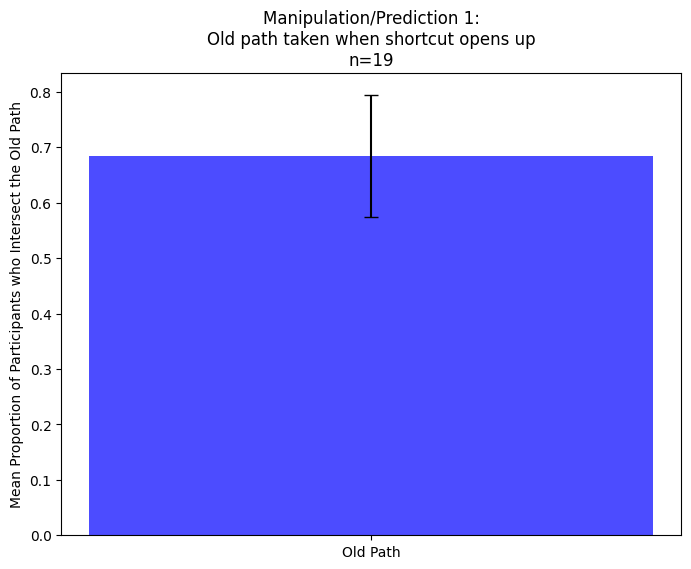

In [50]:
# create empty lists to store choice data
old_path_allsubs=[]
new_path_allsubs=[]

# create counters to assess participant exclusion
subs_eligible=0
subs_included=0

# open each file in the list
for file in file_list:
    if is_ds_store(file):
        continue
    filename = file.split('/')[-1]
    #print('Processing ' + filename)
    subs_eligible+=1

    # load data from the current participant
    df = pd.read_csv(file)

    if filename in exclude_training_cond1:
        continue

    # isolate data for manipulation 1
    df_1 = df[df['manipulation']==1]

    # further isolate evaluation data
    df_1_eval = df_1[df_1['eval']==True]

    # only include data from participants who reached the goal object on all relevant eval trials
    if df_1_eval['goal_object_reached'].all()<1:
        continue
        
    if 'crossed_old_path' not in df_1_eval.columns:
        print(filename + ' missing relevant columns')
        continue
    subs_included+=1
        
    old_path_allsubs.append(df_1_eval['crossed_old_path'])
    new_path_allsubs.append(df_1_eval['crossed_new_path'])

print('Participants intersecting old path: ' + str(np.mean(old_path_allsubs,dtype=np.float64)))
print('Participants intersecting new path: ' + str(np.mean(new_path_allsubs,dtype=np.float64)))

# how many participants do we have for the analysis?
print('Retained ' + str(subs_included) + ' / ' + str(subs_eligible) + ' participants for analysis')

# test whether proportion of intersects to old path is significantly above chance (50%)
old_path_allsubs = np.array(old_path_allsubs, dtype=np.float64)
title_str='Manipulation/Prediction 1:\nOld path taken when shortcut opens up\nn=' + str(subs_included)
results_manipulation1=run_intersection_analysis(old_path_allsubs,title_str)


In [13]:
print(df_1_eval)

    ID  age     sex     block  manipulation     stage  eval  episode_idx  \
58   7   47  Female  shortcut             1  shortcut  True            1   

    global_episode_idx goal_object_string  goal_object_numeric  \
58                  58             orange                   29   

    goal_object_reached crossed_old_path crossed_new_path  \
58                 True             True            False   

                                              actions  \
58  [0, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, ...   

                                       reaction_times  room  \
58  [1215.0, 298.0, 219.0, 203.0, 171.0, 174.0, 17...     0   

                                            positions  
58  [[14, 0], [14, 1], [14, 2], [13, 2], [12, 2], ...  


# Manipulation 2: Faster when on-path but further than off-path but closer

Retained 18 / 26 participants for analysis
Shapiro-Wilk test p-value (duration): 0.0008942842315962489
Wilcoxon signed-rank test statistic (duration): 40.0
Wilcoxon signed-rank test p-value (duration): 0.04827880859375


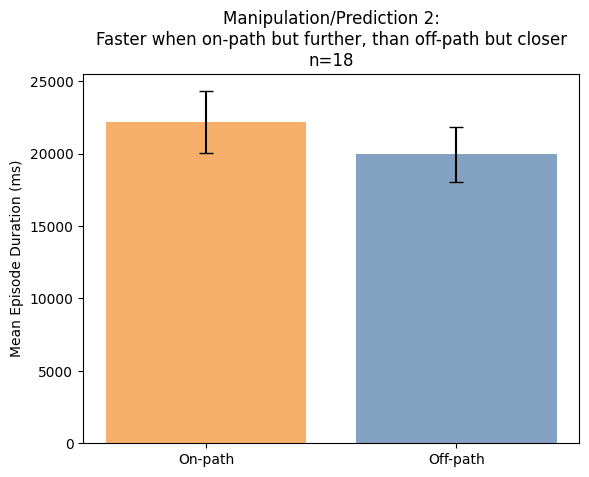

/Users/hall-mcmaster/miniconda3/envs/human-dyna-web-arm64/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


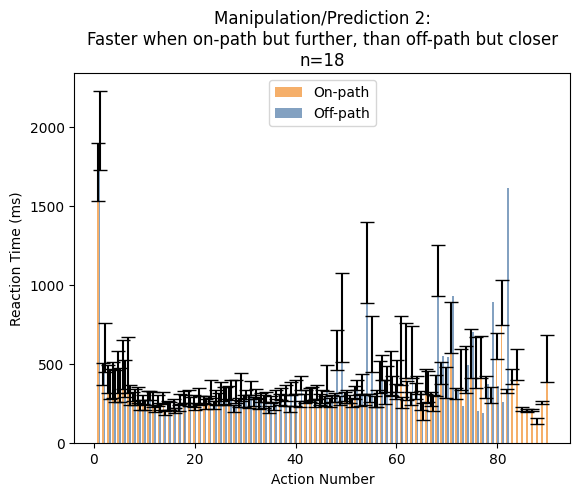

Shapiro-Wilk test p-value (first RT): 0.0256766187147122
Wilcoxon signed-rank test statistic (first RT): 60.0
Wilcoxon signed-rank test p-value (first RT): 0.28372955322265625


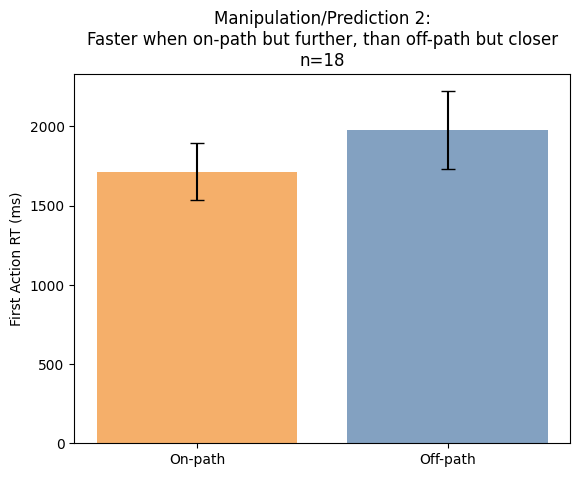

In [51]:
# create empty lists to store RT data
RTs_on_path_allsubs=[]
RTs_off_path_allsubs=[]

# create counters to assess participant exclusion
subs_eligible=0
subs_included=0

# open each file in the list
for file in file_list:
    if is_ds_store(file):
        continue
    filename = file.split('/')[-1]
    #print('Processing ' + filename)
    subs_eligible+=1

    # load data from the current participant
    df = pd.read_csv(file)

    if filename in exclude_training_cond2:
        continue

    # isolate data for manipulation 2
    df_2 = df[df['manipulation']==2]

    # further isolate evaluation data
    df_2_eval = df_2[df_2['eval']==True]

    # only include data from participants who reached the goal object on all relevant eval trials
    if df_2_eval['goal_object_reached'].all()<1:
        continue
    
    # get RTs for the two critical evaluations
    if exp_string=='pilot-1':
        RTs_on_path=df_2_eval.reaction_times[df_2_eval['stage']=='Map changed, new location, on path']
        RTs_off_path=df_2_eval.reaction_times[df_2_eval['stage']=='Map changed, new location, off-path']
    else: 
        RTs_on_path=df_2_eval.reaction_times[df_2_eval['stage']=='new location, on-path']
        RTs_off_path=df_2_eval.reaction_times[df_2_eval['stage']=='new location, off-path']

    if len(RTs_on_path) == 0:
        continue

    subs_included+=1
    
    # convert from strings to array
    cleaned_string = RTs_on_path.values[0].strip('[]')
    string_numbers = cleaned_string.split(',')
    float_list = [float(x) for x in string_numbers]
    RTs_on_path_array = np.array(float_list)

    cleaned_string = RTs_off_path.values[0].strip('[]')
    string_numbers = cleaned_string.split(',')
    float_list = [float(x) for x in string_numbers]
    RTs_off_path_array = np.array(float_list)

    # concatenate
    RTs_on_path_allsubs.append(RTs_on_path_array)
    RTs_off_path_allsubs.append(RTs_off_path_array)
    
# how many participants do we have for the analysis?
print('Retained ' + str(subs_included) + ' / ' + str(subs_eligible) + ' participants for analysis')

# run analyses based on RT
title_str='Manipulation/Prediction 2:\nFaster when on-path but further, than off-path but closer\nn=' + str(subs_included)
path_str=['On-path', 'Off-path']
results_manipulation2 = run_RT_analysis(RTs_on_path_allsubs, RTs_off_path_allsubs, title_str, path_str)



# Manipulation 3: Reusing longer of two paths which matches the training path

Participants intersecting old path: 0.9
Participants intersecting new path: 0.1
Retained 10 / 26 participants for analysis
Shapiro-Wilk test result: ShapiroResult(statistic=np.float64(0.36572062769765235), pvalue=np.float64(1.0036928213864587e-07))
Data is not normally distributed. Proceeding with Wilcoxon signed-rank test.
Wilcoxon test result: WilcoxonResult(statistic=array([5.5]), pvalue=array([0.02734375]))


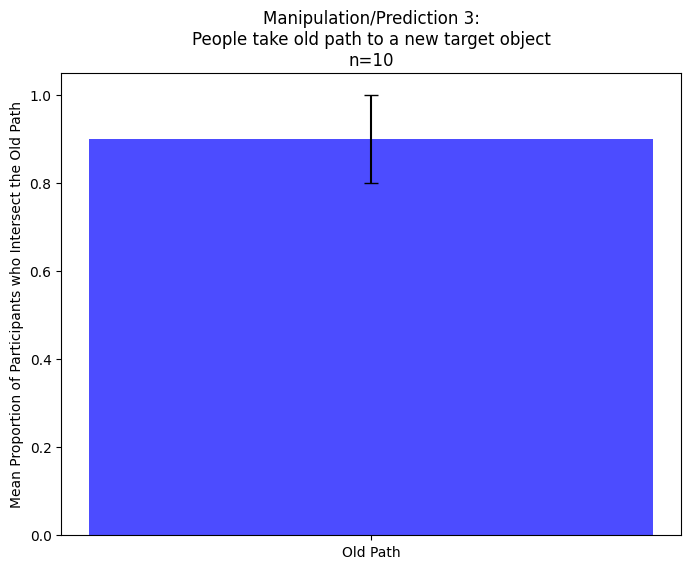

In [52]:
# create empty lists to store choice data
old_path_allsubs=[]
new_path_allsubs=[]

# create counters to assess participant exclusion
subs_eligible=0
subs_included=0

# open each file in the list
for file in file_list:
    if is_ds_store(file):
        continue
    filename = file.split('/')[-1]
    #print('Processing ' + filename)
    subs_eligible+=1

    # load data from the current participant
    df = pd.read_csv(file)

    if filename in exclude_training_cond3:
        continue

    # isolate data for manipulation 3
    df_3 = df[df['manipulation']==3]

    # further isolate evaluation data
    df_3_eval = df_3[df_3['eval']==True]

    # only include data from participants who reached the goal object on all relevant eval trials
    if df_3_eval['goal_object_reached'].all()<1:
        continue

    if 'crossed_old_path' not in df_3_eval.columns:
        print(filename + ' missing relevant columns')
        continue

    subs_included+=1
        
    old_path_allsubs.append(df_3_eval['crossed_old_path'])
    new_path_allsubs.append(df_3_eval['crossed_new_path'])

print('Participants intersecting old path: ' + str(np.mean(old_path_allsubs)))
print('Participants intersecting new path: ' + str(np.mean(new_path_allsubs)))

# how many participants do we have for the analysis?
print('Retained ' + str(subs_included) + ' / ' + str(subs_eligible) + ' participants for analysis')

# test whether proportion of intersects to old path is significantly above chance (50%)
old_path_allsubs = np.array(old_path_allsubs, dtype=np.float64)

title_str='Manipulation/Prediction 3:\nPeople take old path to a new target object\nn=' + str(subs_included)
results_manipulation1=run_intersection_analysis(old_path_allsubs,title_str)

# Manipulation 4: Probing for planning near goal (pilot-1 only)

Processing sub-03.csv
Processing sub-02.csv
Processing sub-01.csv
Processing sub-05.csv
Processing sub-04.csv
Processing sub-06.csv
Retained 4 / 6 participants for analysis
Shapiro-Wilk test p-value: 0.6086108033287053
Paired t-test statistic: 1.2684079928807726
Paired t-test p-value: 0.29413767734806445


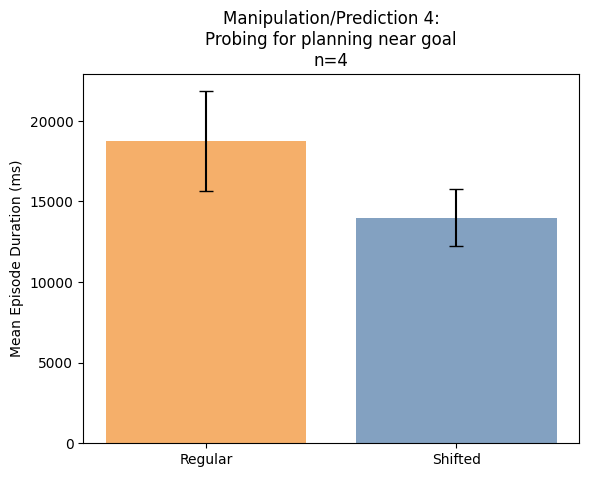

/Users/hall-mcmaster/miniconda3/envs/human-dyna-web/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


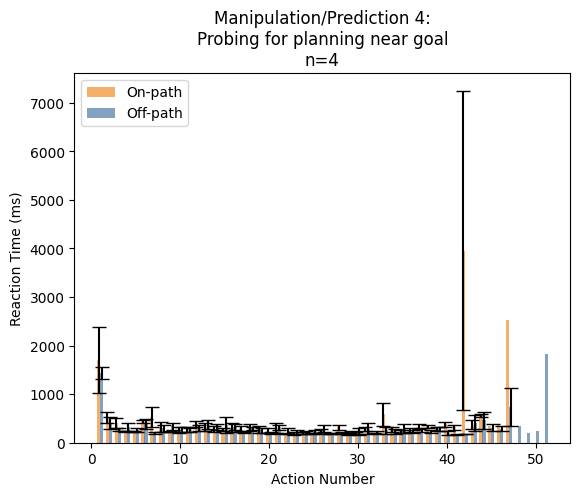

In [51]:
# the main idea behind this manipulation is the following:
# 1. If people are following the original training path and planning only at the very end, 
# RTs should be similar when we move the goal object to a different equidistant location at evaluation
# (although there are other reasons one might fail to see a difference in RTs)

# 2. If people have already cached the whole path to the evaluation object, 
# RTs should be faster when the goal object is in its original location (relative to training),
# compared to its shifted location


# create empty lists to store RT data
RTs_reg_path_allsubs=[]
RTs_flip_path_allsubs=[]

# create counters to assess participant exclusion
subs_eligible=0
subs_included=0

# open each file in the list
for file in file_list:
    if is_ds_store(file):
        continue
    filename = file.split('/')[-1]
    print('Processing ' + filename)
    subs_eligible+=1

    # load data from the current participant
    df = pd.read_csv(file)

    # isolate data for manipulation 4
    df_4 = df[df['manipulation']==4]

    # further isolate evaluation data
    df_4_eval = df_4[df_4['eval']==True]

    # only include data from participants who reached the goal object on all relevant eval trials
    if df_4_eval['goal_object_reached'].all()<1:
        continue
    subs_included+=1

   # get RTs for the two critical evaluations
    RTs_reg_path=df_4_eval.reaction_times[df_4_eval['stage']=='off-task object regular']
    RTs_flip_path=df_4_eval.reaction_times[df_4_eval['stage']=='off-task object flipped']

    # convert from strings to array
    cleaned_string = RTs_reg_path.values[0].strip('[]')
    string_numbers = cleaned_string.split(',')
    float_list = [float(x) for x in string_numbers]
    RTs_reg_path_array = np.array(float_list)

    cleaned_string = RTs_flip_path.values[0].strip('[]')
    string_numbers = cleaned_string.split(',')
    float_list = [float(x) for x in string_numbers]
    RTs_flip_path_array = np.array(float_list)

    # concatenate
    RTs_reg_path_allsubs.append(RTs_reg_path_array)
    RTs_flip_path_allsubs.append(RTs_flip_path_array)
    
# how many participants do we have for the analysis?
print('Retained ' + str(subs_included) + ' / ' + str(subs_eligible) + ' participants for analysis')

title_str='Manipulation/Prediction 4:\nProbing for planning near goal\nn=' + str(subs_included)
path_str=['Regular', 'Shifted']
results_manipulation4 = run_RT_analysis(RTs_reg_path_allsubs, RTs_flip_path_allsubs, title_str, path_str)


